**Input**
- PLINK2 GWAS summary statistics
- MAGMA gene analysis results

**Source**
- From Pan-UKBB summary statistics
- From my own GWAS

Both are based on the same data, and therefore must yield the same result

**Phenotype**  
1180 Morning/evening person (chronotype)

**Population**
- Pan-UKBB: EUR (European)
- My own GWAS: White-British

**Process: calculate the following**
- PLINK2
  - Scatter plot of SNP-wise comparison (between Pan-UKBB and my own GWAS)
    - All SNPs
    - Statistically significant SNPs
- MAGMA
  - Adding info
    - Bonferroni-corrected P-values (also written P-Bonf)
    - q-values (also known as FDR-adjusted p-values)
    - Annotation of whether those values are under FDR threshold
  - Scatter plot of SNP-wise comparison (between Pan-UKBB and my own GWAS)
    - All SNPs
    - Statistically significant SNPs

# Preparation (Execute all in this section!)

## Import libraries & set environment variables

In [1]:
import collections
from datetime import datetime
import os
import numpy as np
from pathlib import Path
import polars as pl
import re
import textwrap

import warnings
# suppress DeprecationWarning messages
warnings.filterwarnings("ignore", category=DeprecationWarning)

from matplotlib import pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

# Draw flowcharts using Mermaid
import base64
from IPython.display import Image, display

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))

dir_home = Path(os.getcwd()).parent.parent.parent
os.chdir(dir_home)
print("Current directory (check that it's your home directory):", os.getcwd())

Current directory (check that it's your home directory): J:\sugai\UKBiobank


In [2]:
mm("""
graph TD;
    classDef dark fill:#DDDDDD, stroke:#DDDDDD, font-size:12px
    UKBB --My analysis_small--> White_My_small[White British: 300K</br>Variants:9M]
    UKBB --My analysis_large--> White_My_large[White British: 80K</br>Variants:9M]
    UKBB[UKBB</br>Population: 500K</br>Variants: 90M] --Pan-UKBB--> White_Pan[European: 300K</br>Variants: 29M]    
    
    White_My_small --> GWAS_My[GWAS]
    White_My_large --> GWAS_My[GWAS]
    White_Pan --> GWAS_Pan[GWAS]

    GWAS_My --> GeneP[Gene-based P-values]
    GWAS_Pan --> GeneP

""")

## File I/O

In [2]:
# Input: Pan-UKBB summary statistics
FILE_SUMSTAT_PANUKBB_CHRONOTYPE = os.path.join("data", 
                                    "panukbb",
                                    "for_magma",
                                    "per_phenotype",
                                    "continuous-1180-both_sexes.tsv"
                                   )
# Input: MAGMA result from Pan-UKBB
FILE_MAGMA_PANUKBB_CHRONOTYPE = os.path.join("analysis", "specific", 
                       "analysis_20230529_01_gwas",
                       "summary", "1180_comparison_MyGWAS_PanUKBB", 
                       "out.with_p_correction_PanUKBB.csv")

# Input + output: my current results
DIR_MYGWAS_CURRENT = os.path.join("analysis", "specific", 
                                       "analysis_20230705_01_gwas",)
DIR_MYGWAS_SMALL = os.path.join(DIR_MYGWAS_CURRENT, "accel_only")
FILE_SUMSTAT_MYGWAS_SMALL = os.path.join(
    DIR_MYGWAS_SMALL, "pval_for_magma.txt")
FILE_ANNOTATED_MYGWAS_SMALL = os.path.join(
    DIR_MYGWAS_SMALL, "magma", "with_p_correction.csv")

DIR_MYGWAS_LARGE = os.path.join(DIR_MYGWAS_CURRENT, "all")
FILE_SUMSTAT_MYGWAS_LARGE = os.path.join(
    DIR_MYGWAS_LARGE, "pval_for_magma.txt")
FILE_ANNOTATED_MYGWAS_LARGE = os.path.join(
    DIR_MYGWAS_LARGE, "magma", "with_p_correction.csv")


# Output folder
DIR_OUT = os.path.join(DIR_MYGWAS_CURRENT, "summary")
if not os.path.exists(DIR_OUT):
    os.makedirs(DIR_OUT)

FDR_THRESHOLD = 0.05 # Q value threshold

## Functions

In [3]:
def flatten(l):
    for el in l:
        if isinstance(el, collections.abc.Iterable) and not isinstance(el, (str, bytes)):
            yield from flatten(el)
        else:
            yield el


def func_print(i):
    if i < 10 or str(i)[1:].count('0') == len(str(i))-1:
        now = datetime.now()
        print(f"{now.strftime('%Y-%m-%d %H:%M:%S')}: {i}")
        

def func_process(FILE_SOURCE, FILE_OUTPUT):
    print("Processing:", FILE_SOURCE)
    # Read as String to avoid any automatic conversion
    df = (pl.read_csv(FILE_SOURCE, 
                      separator=",", 
                      infer_schema_length=0)
          .drop_nulls()
          .with_columns(pl.col("P").cast(pl.Float32).alias("P_Bonf"))
          .with_columns(pl.col("P").cast(pl.Float32).alias("P_log10"))
          .with_columns(pl.col("P").cast(pl.Float32).alias("Q"))
          .with_columns(np.log10(pl.col("P_log10")))
          .sort(by='Q'))

    n_count = df['Q'].is_not_null().sum()

    df = (df
          # Calculate Bonferroni-corrected P values
          .with_columns(pl.col('P_Bonf') * n_count)
           # create a new column which is true if "P_Bonf" is under threshold
          .with_columns((pl.col("P_Bonf") < FDR_THRESHOLD).alias("Positive_P_Bonf"))
          # Calculate Q values
          # Multiply Q column by number of non-null values
          .with_columns(pl.col('Q') * n_count)
          # # Divide the Q columns by the rank of individual value among all the non-null values
          .with_columns(pl.col('Q') / df['Q'].rank())
          # create a new column which is true if "q" is under threshold
          .with_columns((pl.col("Q") < FDR_THRESHOLD).alias("Positive_Q"))
          # Add log10 values
          .with_columns(pl.col("P_Bonf").alias("P_Bonf_log10"))
          .with_columns(np.log10(pl.col("P_Bonf_log10")))
          .with_columns(pl.col("Q").alias("Q_log10"))
          .with_columns(np.log10(pl.col("Q_log10")))
          # Sort
          .sort(by='Positive_P_Bonf', descending=True)
         )
    df.write_csv(FILE_OUTPUT)
    
    
def func_list_genes(FILE_SOURCE, col_gene="Gene"):
    df_all = pl.read_csv(FILE_SOURCE, separator=",")
    df_positive = df_all.filter(pl.col("Positive_P_Bonf"))
    set_genes_all = set(df_all[col_gene])
    set_genes_positive = set(df_positive[col_gene])
    print("All =", len(set_genes_all), "genes, positive =", len(set_genes_positive), "genes")
    return set_genes_all, set_genes_positive


def polars_read(FILE, rename_col):
    print(datetime.now(), "Loading", FILE)
    df = (pl.read_csv(FILE, 
                      separator=" ", 
                      infer_schema_length=0)
          .with_columns(pl.col("P").cast(pl.Float64))
          .rename({"P": rename_col})
         )
    print(df.head)
    return df
    

# Draw p-value scatter plot
def func_compare_pval(df_1, df_2, col_common,
                      graph_title,
                      col1, col2, label1, label2, is_log, plot_unit): 
    df_sumstat_comparison = df_1.join(df_2, on=col_common, how="inner").drop_nulls()
    
    # Scatter plot
    fig, ax = plt.subplots(figsize=[5, 5])
    x = df_sumstat_comparison[col1].to_numpy()
    y = df_sumstat_comparison[col2].to_numpy()
    if not is_log:
        x = np.log10(x)
        y = np.log10(y)

    print(col1, col2, ": corr =", np.corrcoef(x, y)[0, 1])

    ax.scatter(x, y, s=2)
    line1, = ax.plot(np.linspace(-30, 0, 10), np.linspace(-30, 0, 10),
                    linestyle="dashed", color = "crimson", alpha = 0.5,)

    ax.set_xlim(-plot_unit * 3, 0)
    ax.set_ylim(-plot_unit * 3, 0)
    ax.set_xticks([-plot_unit * 3, -plot_unit * 2, -plot_unit, 0]) 
    ax.set_yticks([-plot_unit * 3, -plot_unit * 2, -plot_unit, 0]) 

    ax.set_xlabel(label1, fontsize=20)
    ax.set_ylabel(label2, fontsize=20)
    ax.set_title(graph_title, fontsize=24)
    plt.show()
    
    data1 = df_1[col1].to_numpy()
    data2 = df_2[col2].to_numpy()
    if not is_log:
        data1 = np.log10(data1)
        data2 = np.log10(data2)

    # Histogram for each
    fig, ax = plt.subplots(figsize=[5, 5])
    ax.set_xlabel(graph_title, fontsize=22)
    ax.set_ylabel("Count", fontsize=24)
    ax.set_yscale('log')
    ax.hist(data2, # different from y: the whole data
            alpha=0.5, label=label2, density=False, bins=100, color="green")
    ax.hist(data1, # different from x: the whole data
            alpha=1, label=label1, density=False, bins=100, color='#f48d63')
    ax.legend(fontsize=20)

    plt.show()
    
# Draw Venn diagrams - 2 sets
def func_venn2(set_genes_1, set_genes_2, list_names):
    plt.rcParams["figure.figsize"] = [3.5, 3.5]
    plt.rcParams["figure.autolayout"] = True

    out = venn2(
        [set_genes_1, set_genes_2], 
          list_names
               )
    
    for text in out.set_labels:
        text.set_fontsize(14)
    try: # Sometimes it fails because no intersect exists
        for text in out.subset_labels:
            text.set_fontsize(12)
    except:
        pass
    plt.show()

# Process summary statistics

## Read files

### Chronotype

In [4]:
df_sumstat_mygwas_small = polars_read(FILE_SUMSTAT_MYGWAS_SMALL, "P_MyGWAS_SMALL")
df_sumstat_mygwas_large = polars_read(FILE_SUMSTAT_MYGWAS_LARGE, "P_MyGWAS_LARGE")
df_sumstat_panukbb = polars_read(FILE_SUMSTAT_PANUKBB_CHRONOTYPE, "P_PanUKBB")

2023-07-14 14:40:32.627450 Loading analysis\specific\analysis_20230705_01_gwas\accel_only\pval_for_magma.txt
<bound method DataFrame.head of shape: (9_437_885, 2)
┌──────────────────────┬────────────────┐
│ SNP                  ┆ P_MyGWAS_SMALL │
│ ---                  ┆ ---            │
│ str                  ┆ f64            │
╞══════════════════════╪════════════════╡
│ 1:182569626[b37]T,C  ┆ 1.1564e-10     │
│ 1:182573227[b37]T,C  ┆ 1.2429e-10     │
│ 1:182548483[b37]GC,G ┆ 2.1521e-10     │
│ 1:182558139[b37]G,T  ┆ 2.1549e-10     │
│ …                    ┆ …              │
│ 12:13498892[b37]G,A  ┆ 0.999999       │
│ 1:230450968[b37]A,C  ┆ 0.999999       │
│ 3:673524[b37]T,C     ┆ 0.999999       │
│ 16:85966329[b37]A,T  ┆ 1.0            │
└──────────────────────┴────────────────┘>
2023-07-14 14:40:51.309186 Loading analysis\specific\analysis_20230705_01_gwas\all\pval_for_magma.txt
<bound method DataFrame.head of shape: (9_437_885, 2)
┌────────────────────────┬────────────────┐
│ SNP 

## Compare P-values

P_MyGWAS_SMALL P_PanUKBB : corr = 0.2995757183565693


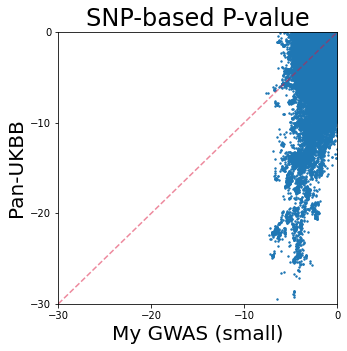

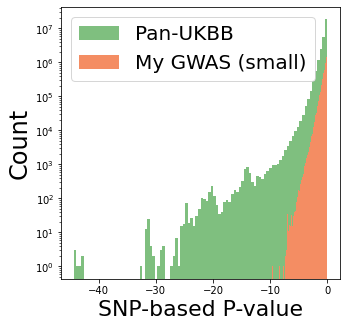

P_MyGWAS_LARGE P_PanUKBB : corr = 0.9146458190255058


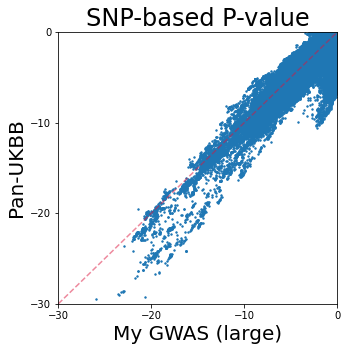

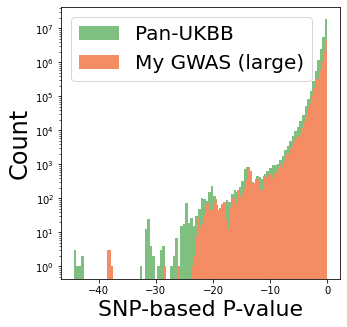

P_MyGWAS_SMALL P_MyGWAS_LARGE : corr = 0.3246077436995637


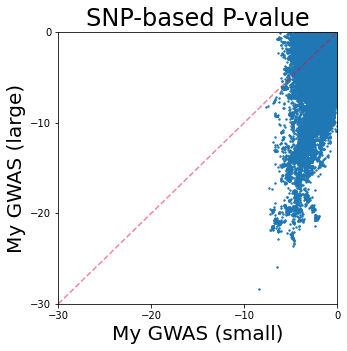

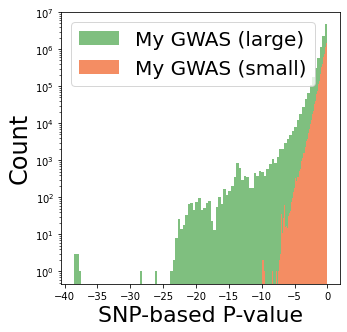

In [7]:
func_compare_pval(df_sumstat_mygwas_small, df_sumstat_panukbb, "SNP",
                  "SNP-based P-value",
                  "P_MyGWAS_SMALL", "P_PanUKBB", 
                  "My GWAS (small)", "Pan-UKBB", 
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_large, df_sumstat_panukbb, "SNP",
                  "SNP-based P-value",
                  "P_MyGWAS_LARGE", "P_PanUKBB", 
                  "My GWAS (large)", "Pan-UKBB", 
                  False, 10
                 )

func_compare_pval(df_sumstat_mygwas_small, df_sumstat_mygwas_large, "SNP",
                  "SNP-based P-value",
                  "P_MyGWAS_SMALL", "P_MyGWAS_LARGE", 
                  "My GWAS (small)", "My GWAS (large)", 
                  False, 10
                 )


# Process MAGMA results

## Add Pbonf, q-values, posi/nega annotation

In [8]:
list_files = []
for root, dirs, files in os.walk(DIR_MYGWAS_CURRENT):
    # Check if the target file exists in the current folder
    if "gene_pheno_pval_list_annotated.csv" in files:
        # Get the full path of the file
        file_source = os.path.join(root, "gene_pheno_pval_list_annotated.csv")
        file_out = os.path.join(root, "with_p_correction.csv")
        # Print the file path
        list_files.append([file_source, file_out])

list_files = sorted(list_files)
print(len(list_files), "Files are found")
list_files

2 Files are found


[['analysis\\specific\\analysis_20230705_01_gwas\\accel_only\\magma\\gene_pheno_pval_list_annotated.csv',
  'analysis\\specific\\analysis_20230705_01_gwas\\accel_only\\magma\\with_p_correction.csv'],
 ['analysis\\specific\\analysis_20230705_01_gwas\\all\\magma\\gene_pheno_pval_list_annotated.csv',
  'analysis\\specific\\analysis_20230705_01_gwas\\all\\magma\\with_p_correction.csv']]

In [9]:
list_sets_genes = []

for list_IO in list_files:
    print()
    func_process(list_IO[0], list_IO[1])
    set_genes_all, set_genes_positive = func_list_genes(list_IO[1])
    list_sets_genes.append([list_IO[1], set_genes_all, set_genes_positive])


Processing: analysis\specific\analysis_20230705_01_gwas\accel_only\magma\gene_pheno_pval_list_annotated.csv
All = 17995 genes, positive = 4 genes

Processing: analysis\specific\analysis_20230705_01_gwas\all\magma\gene_pheno_pval_list_annotated.csv
All = 17995 genes, positive = 173 genes


## List up the genes

In [10]:
print("Pan-UKBB")
set_genes_all_panukbb, set_genes_positive_panukbb = \
func_list_genes(FILE_MAGMA_PANUKBB_CHRONOTYPE, col_gene="NAME")
print()

print("My GWAS (small)")
set_genes_all_mygwas_small, set_genes_positive_mygwas_small = \
func_list_genes(FILE_ANNOTATED_MYGWAS_SMALL)
print()

print("My GWAS (large)")
set_genes_all_mygwas_large, set_genes_positive_mygwas_large = \
func_list_genes(FILE_ANNOTATED_MYGWAS_LARGE)
print()

Pan-UKBB
All = 19427 genes, positive = 270 genes

My GWAS (small)
All = 17995 genes, positive = 4 genes

My GWAS (large)
All = 17995 genes, positive = 173 genes



## Draw Venn diagrams

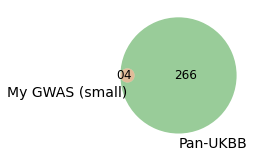

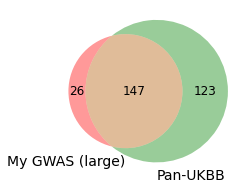

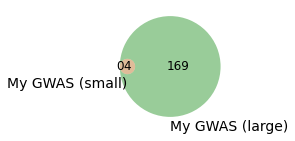

In [11]:
func_venn2(set_genes_positive_mygwas_small, set_genes_positive_panukbb, 
           ["My GWAS (small)", "Pan-UKBB"])
func_venn2(set_genes_positive_mygwas_large, set_genes_positive_panukbb, 
           ["My GWAS (large)", "Pan-UKBB"])
func_venn2(set_genes_positive_mygwas_small, set_genes_positive_mygwas_large, 
           ["My GWAS (small)", "My GWAS (large)"])

In [12]:
print("Only in old", set_genes_positive_mygwas_old - set_genes_positive_mygwas)
print()

print("Only in new", set_genes_positive_mygwas - set_genes_positive_mygwas_old)

Only in old {'RGL1', 'PTPN21', 'KIF21A', 'ZMYND10', 'TTC8', 'PC', 'RBM14', 'CTSF', 'SPATA7'}

Only in new {'SEMA3F', 'MEF2C', 'AKAP5', 'TMEM108', 'PMPCB', 'CAMKV', 'PACS1', 'GNAI3', 'DGKG', 'TMEM161B', 'PHACTR1', 'EPC2', 'UBXN2A', 'PER1', 'ECM1', 'HNRNPD', 'ILKAP', 'KBTBD4', 'ZFP91', 'ZCCHC7', 'PMFBP1', 'NDUFS3', 'FIGNL1', 'ARHGAP15', 'GRB10', 'PREPL', 'CNIH2', 'SCAF11', 'DYNLL1', 'MRPS21', 'CUX1', 'CHAF1A', 'CALB2', 'RASA1', 'HP', 'OR5B2', 'HTR6', 'TES', 'LRRTM4', 'UBXN6', 'SLC18A2', 'PLCL1', 'PRR7', 'PRPF3', 'GPC6', 'NEBL', 'RBM5', 'MACROD2', 'PMPCA', 'HCRTR2', 'NMUR2', 'AXDND1', 'UNC5D', 'POU2F2', 'HPR', 'DAB1', 'PER2', 'INPP5E', 'PDE1C', 'TRAF3IP1', 'ST18', 'EXD3', 'SEC11C', 'FBXO5', 'FBXL17', 'DDC', 'TFEC', 'HYAL2', 'TARS2', 'MST1R', 'KLHL29', 'C1orf54', 'CRY1', 'AP2B1', 'DHODH', 'CBX5', 'EGFL8', 'ORAI2', 'VAMP2', 'ZNF365', 'RNF10', 'ALG10', 'SEC16A', 'PNMAL2', 'FAM132B', 'GRK6', 'ZNF821', 'SLC38A3', 'PTPMT1', 'LOC101927254', 'MYCBP2', 'ZBTB25', 'FAM83B', 'DENND1A', 'UTS2', 'DBN1'

## Compare P-values

In [12]:
df_genebased_mygwas_small = pl.read_csv(FILE_ANNOTATED_MYGWAS_SMALL, separator=",")
df_genebased_mygwas_large = pl.read_csv(FILE_ANNOTATED_MYGWAS_LARGE, separator=",")
df_genebased_panukbb = pl.read_csv(FILE_MAGMA_PANUKBB_CHRONOTYPE, separator=",")

# Extract columns "NAME" and "P"
df_genebased_mygwas_small = (df_genebased_mygwas_small
                       .select(["Gene", "P_log10"])
                       .rename({"P_log10": "Log10P_mygwas_small", "Gene": "NAME"})
                      )

df_genebased_mygwas_large = (df_genebased_mygwas_large
                       .select(["Gene", "P_log10"])
                       .rename({"P_log10": "Log10P_mygwas_large", "Gene": "NAME"})
                      )

df_genebased_panukbb = (df_genebased_panukbb
                        .select(["NAME", "P_log10"])
                        .rename({"P_log10": "Log10P_panukbb"})
                       )

print(df_genebased_mygwas_small.head)
print(df_genebased_mygwas_large.head)
print(df_genebased_panukbb.head)

<bound method DataFrame.head of shape: (17_995, 2)
┌─────────┬─────────────────────┐
│ NAME    ┆ Log10P_mygwas_small │
│ ---     ┆ ---                 │
│ str     ┆ f64                 │
╞═════════╪═════════════════════╡
│ RGS16   ┆ -8.630191           │
│ RNASEL  ┆ -6.464326           │
│ ALG10B  ┆ -6.031961           │
│ C1orf54 ┆ -5.662261           │
│ …       ┆ …                   │
│ SPNS2   ┆ -0.000083           │
│ RNF32   ┆ -0.000078           │
│ HCAR3   ┆ -0.000074           │
│ GPR135  ┆ -0.000026           │
└─────────┴─────────────────────┘>
<bound method DataFrame.head of shape: (17_995, 2)
┌─────────┬─────────────────────┐
│ NAME    ┆ Log10P_mygwas_large │
│ ---     ┆ ---                 │
│ str     ┆ f64                 │
╞═════════╪═════════════════════╡
│ CLN5    ┆ -15.653569          │
│ LRRTM4  ┆ -15.409704          │
│ RBFOX1  ┆ -14.568942          │
│ VAMP3   ┆ -14.28714           │
│ …       ┆ …                   │
│ ELANE   ┆ -0.000187           │
│ GRHL1   ┆ -

Log10P_mygwas_small Log10P_panukbb : corr = 0.35078451548202383


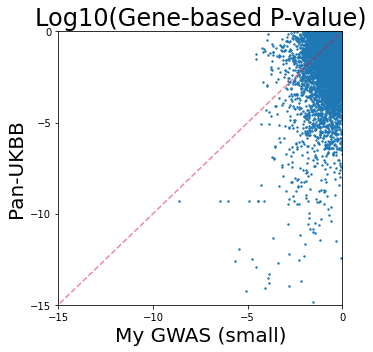

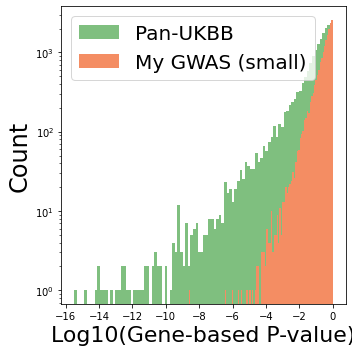

Log10P_mygwas_large Log10P_panukbb : corr = 0.9261785051250432


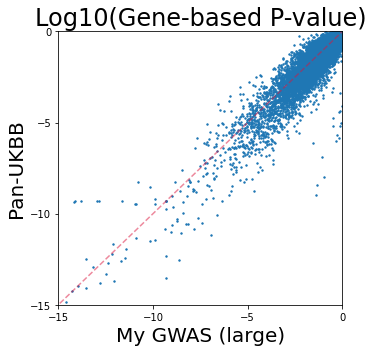

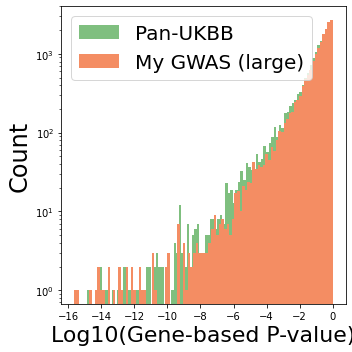

Log10P_mygwas_small Log10P_mygwas_large : corr = 0.39057306987099244


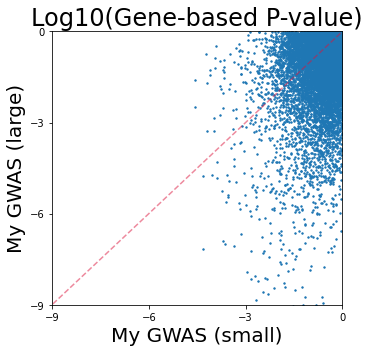

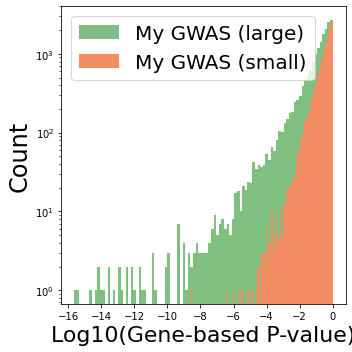

In [13]:
func_compare_pval(df_genebased_mygwas_small, df_genebased_panukbb, "NAME",
                  "Log10(Gene-based P-value)",
                  "Log10P_mygwas_small", "Log10P_panukbb",
                  "My GWAS (small)", "Pan-UKBB",
                  True, 5
                 )

func_compare_pval(df_genebased_mygwas_large, df_genebased_panukbb, "NAME",
                  "Log10(Gene-based P-value)",
                  "Log10P_mygwas_large", "Log10P_panukbb",
                  "My GWAS (large)", "Pan-UKBB",
                  True, 5
                 )

func_compare_pval(df_genebased_mygwas_small, df_genebased_mygwas_large, "NAME",
                  "Log10(Gene-based P-value)",
                  "Log10P_mygwas_small", "Log10P_mygwas_large",
                  "My GWAS (small)", "My GWAS (large)",
                  True, 3
                 )